In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 23 15:12:27 2017

@author: leeto
"""
import os
import json
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize, FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures
from nltk.util import ngrams
from nltk.tag.util import *
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [3]:
CategoryIndexes = {"Caught in/between Objects":0,
                     "Falls":1,
                     "Drowning":2,
                     "Other":3,
                     "Others":3,
                     "Struck By Moving Objects":4,
                     "Collapse of object":5,
                     "Fires and Explosion":6,
                     "Electrocution":7,
                     "Suffocation":8,
                     "Exposure to Chemical Substances":9,
                     "Exposure to extreme temperatures":10,
                     }
CategoryNames = {0:"Caught in/between Objects",
                     1:"Falls",
                     2:"Drowning",
                     3:"Other",
                     4:"Struck By Moving Objects",
                     5:"Collapse of object",
                     6:"Fires and Explosion",
                     7:"Electrocution",
                     8:"Suffocation",
                     9:"Exposure to Chemical Substances",
                     10:"Exposure to extreme temperatures",
                     }

In [4]:
def GetCategoryIndex(Name):
    if Name in CategoryIndexes:
        return CategoryIndexes[Name]
    else:
        return -1
    
def GetCategoryName(Index):
    if (Index in CategoryNames):
        return CategoryNames[Index]
    else:
        return "Invalid Category"
        
#Classes To Be Used 
class Category(object):
    def __init__(self, Name, Index):
        self.Name = Name
        self.Index = Index
        self.ActivityTokensChunk = ""
        self.ActivityTokensVerb = ""
        
    def __str__(self):
        return("Category Item:\n"
               "  Name = {0}({1})\n"
               "  ActivityVerb = {2}\n"
               "  ActivityChunk = {3}\n"
               .format(self.Name, self.Index, self.ActivityTokensVerb ,self.ActivityTokensChunk))
        
class CaseItem(object):
    def __init__(self, Title, Summary, CauseName, CauseIndex):
        self.CauseName = CauseName
        self.CauseIndex = CauseIndex
        self.Title = Title
        self.Summary = Summary
        self.ActivityTokensChunk = ""
        self.ActivityTokensVerb = ""

    def __str__(self):
        return("Case Item:\n"
               "  Cause = {0}({1})\n"
               "  Title = {2}\n"
               "  Summary = {3}\n"
               .format(self.CauseName, self.CauseIndex, self.Title, self.Summary))

In [5]:
#read from excel, populate case items
def ReadFromExcelAndPopulateCase():
    global MsiaCaseItems 
    global OshaCaseItems
    MsiaCaseItems = []
    OshaCaseItems = []
    MsiaCasesDF=pd.read_excel(MsiaCasesFile,sheetname=0)
    OshaDF=pd.read_excel(OshaCasesFile,sheetname=0)
    MsiaCasesDF.groupby('Cause ').describe()
    # For each row in the column,
    for index,row in MsiaCasesDF.iterrows():
        TempCaseItem = CaseItem(row['Title Case'], row['Summary Case'], row['Cause '], GetCategoryIndex(row['Cause ']))
        MsiaCaseItems.append(TempCaseItem)
    # For each row in the column,
    for index,row in OshaDF.iterrows():
        TempCaseItem = CaseItem(row['Title Case'], row['Summary Case'], "", 0)
        OshaCaseItems.append(TempCaseItem)
        
def explore(text):   
    tokens = word_tokenize(text)
    if (len(tokens)>0):
        fd = nltk.FreqDist(tokens)
        fd.most_common(25)
        fd.plot(25)
        # ==== Installation of wordcloud package
        # 1. download wordcloud‑1.3.2‑cp36‑cp36m‑win_amd64.whl from http://www.lfd.uci.edu/~gohlke/pythonlibs/#wordcloud 
        # 2. Copy the file to your current working directory
        # 3. Open command prompt from Tools
        # 4. python -m pip install wordcloud-1.3.2-cp36-cp36m-win_amd64.whl
    
        # 1. Simple cloud
        # Generate a word cloud image
        # Take note that this function requires text string as input
        wc = WordCloud(background_color="white").generate(text)
        # Display the generated image:
        # the matplotlib way:
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()
    else:
        print("explore function no data")

#Initialize Categories array
def InitializeCategories():
    global MsiaCategories
    MsiaCategories = []
    for index in CategoryNames:
        tempcat = Category(GetCategoryName(index),index)
        MsiaCategories.append(tempcat)

def write_to_file(filename, text):
    f = open(filename, 'a')
    f.write(text + '\n')  # python will convert \n to os.linesep
    f.close()  # you can omit in most cases as the destructor will call it

In [6]:
def get_lemma(subtree):        
    return [ WNlemma.lemmatize(t, 'v') for t in subtree ]

def get_stem(subtree):
    return [ Stemmer.stem(t) for t in subtree ]

def get_verb_count(subtree):
    verb_count = 0
    tokens = nltk.pos_tag(word_tokenize(str(subtree))) 
#    print(tokens)
    for tok in tokens:
        if ('\'VBG\'' in str(tok)) or ('\'VB\'' in str(tok)):
            verb_count += 1
    return verb_count

#def simplify_chunk(subtree):
#    if len(subtree)>2:
#        if 
def filter_off_unwanted_chunks(subtree):
    # first words : crashing, causing, involving, doing, being, falling
    filter_first_words = ['crash', 'cause', 'involve', 'do', 'be', 'fall', 'avoid', 'result', 'address', 'have']
    filter_all_words = ['kill', 'carry out work']
    filter_last_words = ['victim', 'work']
    filter_short_words = ['carry', 'perform']   
    for ffw in filter_first_words:
        if (ffw in get_lemma(untag(subtree))[0]):
            return False, subtree
    for flw in filter_last_words:
        if (flw in get_lemma(untag(subtree))[len(subtree)-1]):
            return False, subtree
    for fsw in filter_short_words:
        if ( fsw in str(" ".join(get_lemma(untag(subtree)))) and (len(subtree)<=2) ):
            return False,subtree
    for faw in filter_all_words:
        if ( faw in str(" ".join(get_lemma(untag(subtree)))) ):
            return False, subtree
    return True, subtree

def clean_up_verb(text):
    text = text.replace("carri", "carry")
    text = text.replace("[","").replace("]","").replace("\'","").replace("\"","")
    text = text.replace("\'","").replace("\"","").replace(",","")
    return text

In [7]:
def extract_activities_chunk_and_verb(text):
    global extract_chunk_count
    global extract_verb_count
    chunk_grammar = r"""
        OCC1:{<VBG|VB>+<IN|DT|JJ|RP>*<NN|NN.*>+(<IN|DT|JJ|RP>*<VBG|VB>+<NN|NN.*>+)?}
    """
    verb_grammar = r"""
        OCC2:{<VBG|VB>+}
    """    
#   original OCC:{<VBG|VB>+<IN|DT|JJ|RP>?<NN|NN.*>+<VBG|VB>?}
    ExtractedActivitiesChunk = ""
    ExtractedActivitiesVerb = ""
    if (not text==""):
        chunk_parser = nltk.RegexpParser(chunk_grammar)
        tokens_chunk = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
        tagged_chunk = nltk.pos_tag(tokens_chunk)
        if (len(tagged_chunk) > 0):
            extract_chunk = chunk_parser.parse(tagged_chunk)
            for subtree_chunk in extract_chunk.subtrees(filter=lambda t: 'OCC1' in t.label()):  
                acceptChunk, processed_subtree_chunk = filter_off_unwanted_chunks(subtree_chunk)
                if (acceptChunk == True):
                    extract_chunk_count += 1
                    token_chunk_clean = untag(processed_subtree_chunk)
                    #token_chunk_clean_str = clean_up_verb(str(get_lemma(token_chunk_clean)))
                    token_chunk_clean_str = clean_up_verb(str(token_chunk_clean))
                    print(token_chunk_clean_str + "(" + str(get_verb_count(untag(processed_subtree_chunk))) + ")")
                    ExtractedActivitiesChunk += token_chunk_clean_str + " "
                    verb_parser = nltk.RegexpParser(verb_grammar)
                    tokens_verb = [word for sent in nltk.sent_tokenize(token_chunk_clean_str) for word in nltk.word_tokenize(sent)]
                    tagged_verb = nltk.pos_tag(tokens_verb)
                    if (len(tagged_verb) > 0):
                        extract_verbs = verb_parser.parse(tagged_verb)
                        for subtree_verb in extract_verbs.subtrees(filter=lambda t: 'OCC2' in t.label()):  
                            extract_verb_count += len(subtree_verb)
                            #print(subtree_verb)
                            tokens_verb_lem = get_lemma(untag(subtree_verb))   
                            tokens_verb_lem_clean = clean_up_verb(str(tokens_verb_lem))
                            #print(tokens_verb_lem_clean)
                            ExtractedActivitiesVerb += clean_up_verb(str(tokens_verb_lem_clean)) + " "
    return ExtractedActivitiesChunk, ExtractedActivitiesVerb

In [8]:
    # Initialize     
    MsiaCategories = []
    MsiaCaseItems = []
    OshaCategories = []
    OshaCaseItems = []
    MsiaCasesFile = 'MsiaAccidentCases.xlsx'
    OshaCasesFile = 'osha.xlsx'
    
    #NLTK Objects
    # lemmatize to convert to base words depending on speech tagging
    WNlemma = nltk.WordNetLemmatizer()
    # stemmer to get the base words
    Stemmer = nltk.SnowballStemmer('english')   
    
    #Initilize categories
    InitializeCategories()
    #Read data from excel and populate case items
    ReadFromExcelAndPopulateCase()

In [9]:
    # if False, means process the Osha dataset
    ProcessMsiaDataSet = True
    extract_chunk_count = 0
    extract_verb_count = 0

maintain excavator magnet machine(0)
turn on excavator engine(0)
installing wood plate(1)
wear a harness(0)
carrying the job of binding Reinforcement Steel Cage(2)
climbing up the cage(1)
coal explosion(0)
stop that machine(0)
move the Tunnel Form(0)
performing cable pulling job(2)
opening the clutch door(1)
dismantling Shear Wall(1)
working platform(1)
find the job(0)
controlling the traffic(1)
working in an open area(1)
entering the room(1)
move the box containing foods(1)
moving forklift(1)
carrying mold installation(1)
stepping on the hollow section(1)
working area(1)
replacing the bricks(1)
using forklift(1)
wrapping plastic tubing(2)
breaking the stone(1)
lying on the floor(1)
repair the Gear Box(0)
working platform(1)
unchained the lorry(0)
cutting down trees(1)
lifting a bundle(1)
working radius(1)
excessive load(0)
cutting down trees(1)
lifting a pile(1)
got out of the cabin(0)
lift the lifting tray(1)
removing the glass door(1)
containing glass door(1)
tagging the name(1)
sta

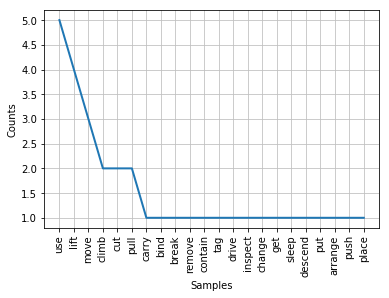

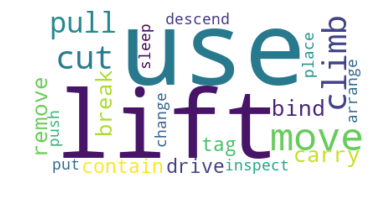

Falls


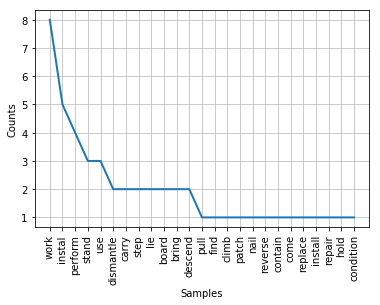

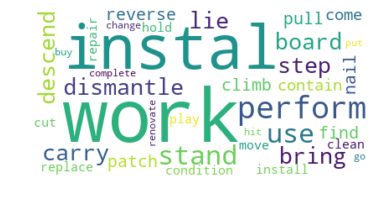

Drowning


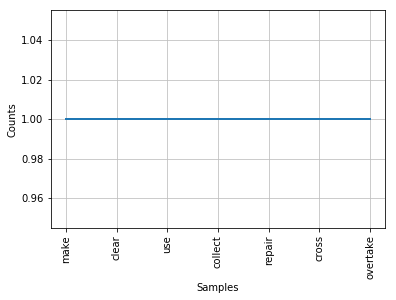

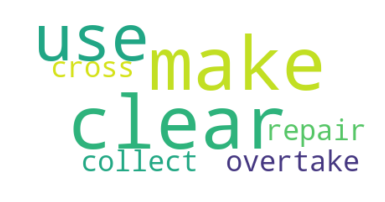

Other


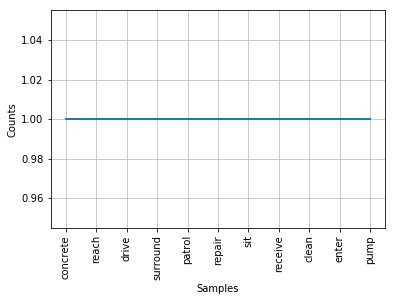

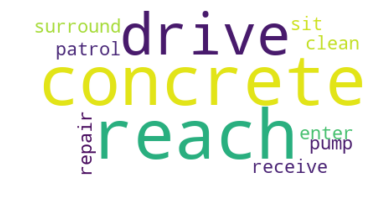

Struck By Moving Objects


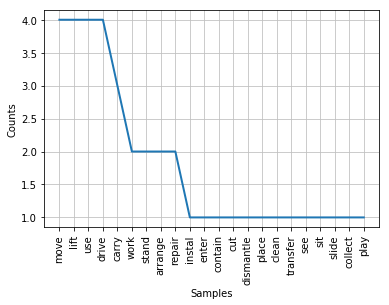

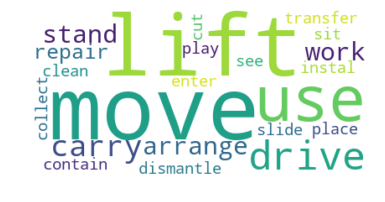

Collapse of object


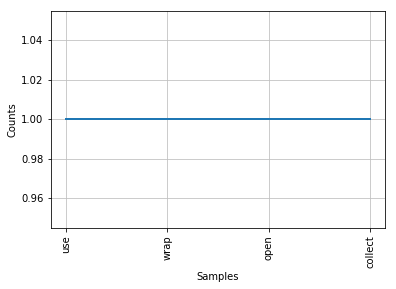

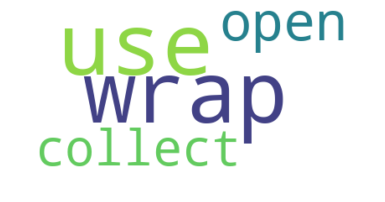

Fires and Explosion


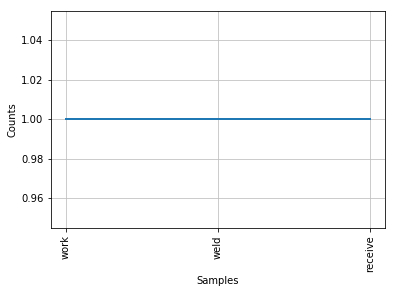

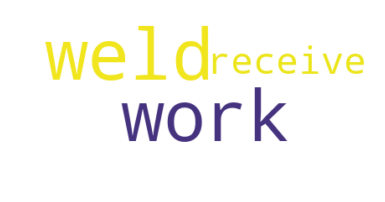

Electrocution


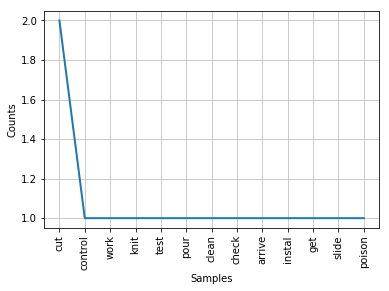

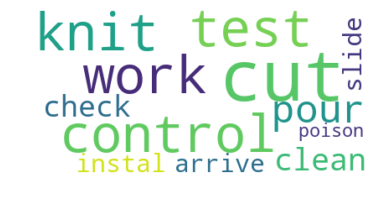

Suffocation


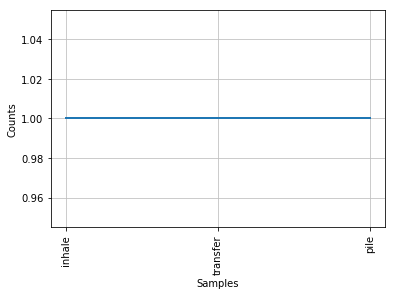

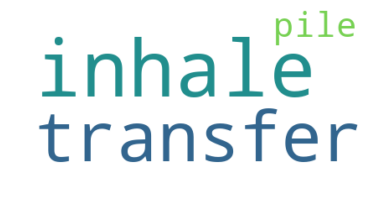

Exposure to extreme temperatures


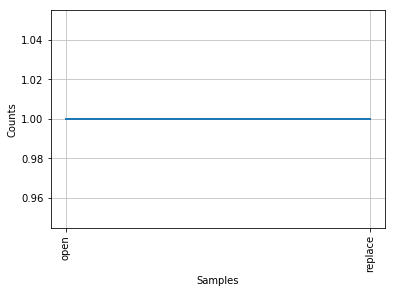

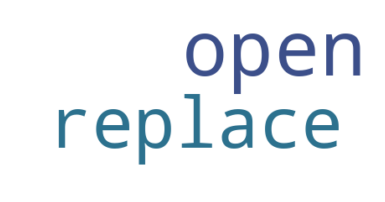

In [10]:
    if (ProcessMsiaDataSet):
        #Populate Activity Tokens for CaseItems and Categories
        for caseitem in MsiaCaseItems:
            caseitem.ActivityTokensChunk,caseitem.ActivityTokensVerb = extract_activities_chunk_and_verb(str(caseitem.Summary))
            for cat in MsiaCategories:
                if int(caseitem.CauseIndex) == int(cat.Index):
                    cat.ActivityTokensVerb += caseitem.ActivityTokensVerb + " "  
                    
        for cat in MsiaCategories:
            if (len(cat.ActivityTokensVerb.replace(" ",""))>0):
                print(cat.Name)
                explore(cat.ActivityTokensVerb)
    else:
        OshaVerb = ""              
        for caseitem in OshaCaseItems:
            caseitem.ActivityTokensChunk, caseitem.ActivityTokensVerb = extract_activities_chunk_and_verb(str(caseitem.Summary))
            OshaVerb += caseitem.ActivityTokensVerb + " "
        explore(OshaVerb)


In [11]:
    print("Extraction Chunk Count is " +  str(extract_chunk_count))
    print("Extraction Verb Count is " +  str(extract_verb_count))    


Extraction Chunk Count is 200
Extraction Verb Count is 179
